In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [7]:
# Read the JSON file with line-separated JSON objects
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [8]:
# Drop link and date which would not be used as a feature
df = df.drop(columns=["link", "date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
 3   authors            209527 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


In [9]:
# EDA: Check for missing values
missing_values = df.isnull().sum()

# Display missing values count per column
print("Number of missing values:", missing_values, sep="\n")

Number of missing values:
headline             0
category             0
short_description    0
authors              0
dtype: int64


In [10]:
# EDA: Check for duplicates
duplicate_rows = df.duplicated()

# Count how many duplicates there are
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 447


In [11]:
# EDA: Remove duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209080 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209080 non-null  object
 1   category           209080 non-null  object
 2   short_description  209080 non-null  object
 3   authors            209080 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


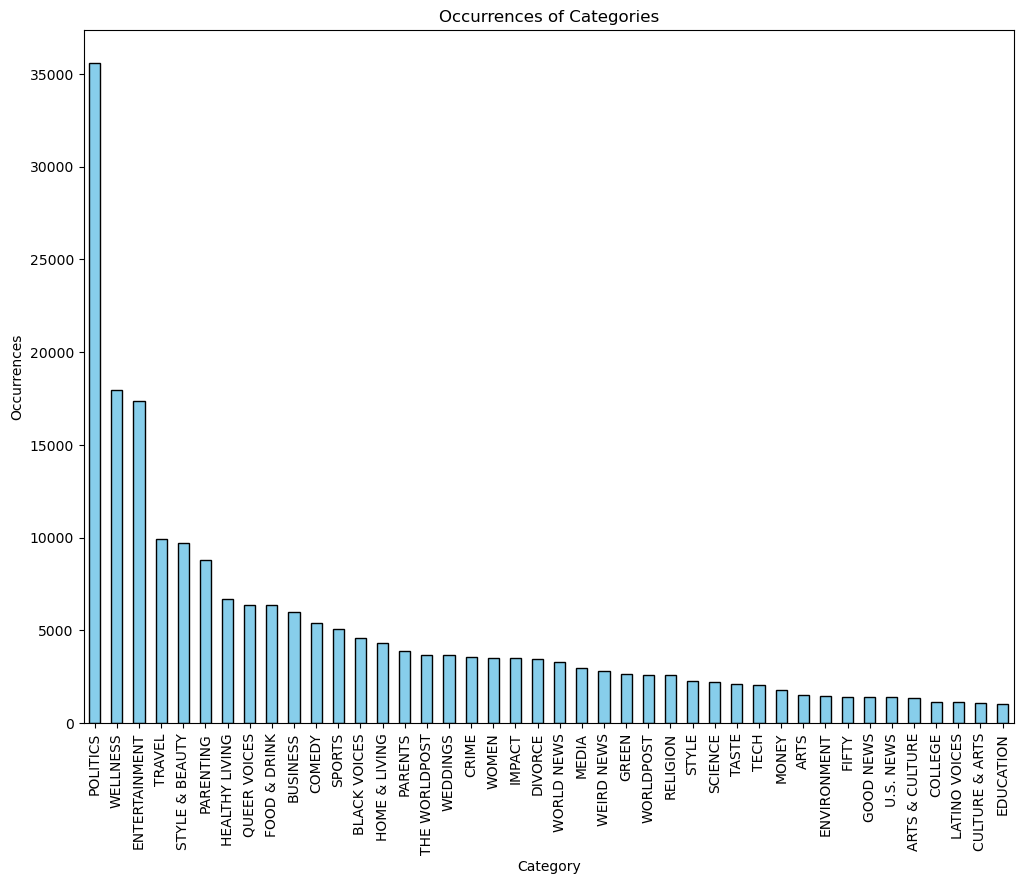

In [36]:
# EDA: Distribution of categories

# Count occurrences of each category
category_counts = df['category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 9))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Occurrences')
plt.title('Occurrences of Categories')

# Display the plot
plt.show()

In [12]:
# Tokenization, stop word removal, and lemmatization

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and non-alphabetic tokens, and lemmatize the remaining words
    cleaned_tokens = [
        lemmatizer.lemmatize(word.lower())  # Convert to lowercase then lemmatize
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return " ".join(cleaned_tokens)

# Iterate through both 'headline' and 'summary' columns
for index, row in df.iterrows():
    df.at[index, 'headline'] = preprocess_text(row['headline'])
    df.at[index, 'short_description'] = preprocess_text(row['short_description'])

# test differnce

df.head()

,headline,category,short_description,authors
0,million american roll sleeve covid booster,U.S. NEWS,health expert said early predict whether deman...,"Carla K. Johnson, AP"
1,american airline flyer charged banned life pun...,U.S. NEWS,subdued passenger crew fled back aircraft conf...,Mary Papenfuss
2,funniest tweet cat dog week,COMEDY,dog understand could eaten,Elyse Wanshel
3,funniest tweet parent week,PARENTING,accidentally put toothpaste toddler toothbrush...,Caroline Bologna
4,woman called cop black loses lawsuit,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski


In [48]:
# Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(df['short_description'], df['category'], test_size=0.2, random_seed=13)

# Step 2: Tokenizer and Dataset Class for BERT Input
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        # Tokenizing the text
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        # Return the tokenized text and corresponding label
        return { 'input_ids': encoding['input_ids'].squeeze(0),
                 'attention_mask': encoding['attention_mask'].squeeze(0),
                 'labels': torch.tensor(label, dtype=torch.long) }

# Step 3: Create DataLoader for train/test sets
train_dataset = TextDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TextDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 4: Initialize BERT for sequence classification
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # MPS for Mac, fall back to CPU if not available
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y_train.unique()))
model.to(device)

# Step 5: Set Up Optimizer and Loss Function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)  # Learning rate for fine-tuning
loss_fn = torch.nn.CrossEntropyLoss()

# Step 6: Fine-Tuning the BERT Model
model.train()
epochs = 3
for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move batch to device (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Get logits (predictions)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Compute loss
        loss = loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

# Step 7: Evaluate the Model on Test Set
model.eval()  # Set model to evaluation mode
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions (class with highest logit)
        predictions = torch.argmax(logits, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Step 8: Evaluate Performance
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Optional: Save the fine-tuned model for future use
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')


FileNotFoundError: [Errno 2] No such file or directory: 'your_dataset.csv'

In [43]:
# Store as parquet file for efficiency
df.to_parquet('bert_transformed.parquet')